In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator


In [2]:

#read the KDDTrain+.txt file
data = pd.read_csv('KDDTrain+.txt', header=None)
#import the KDDTest+.txt file
data_test = pd.read_csv('KDDTest+.txt', header=None)


#initialize the column names
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
           'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
           'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

#assign the column names to the data
data.columns = columns

# data.head()
data.shape

#assign the column names to the data
data_test.columns = columns
print(data_test.shape)


(22544, 43)


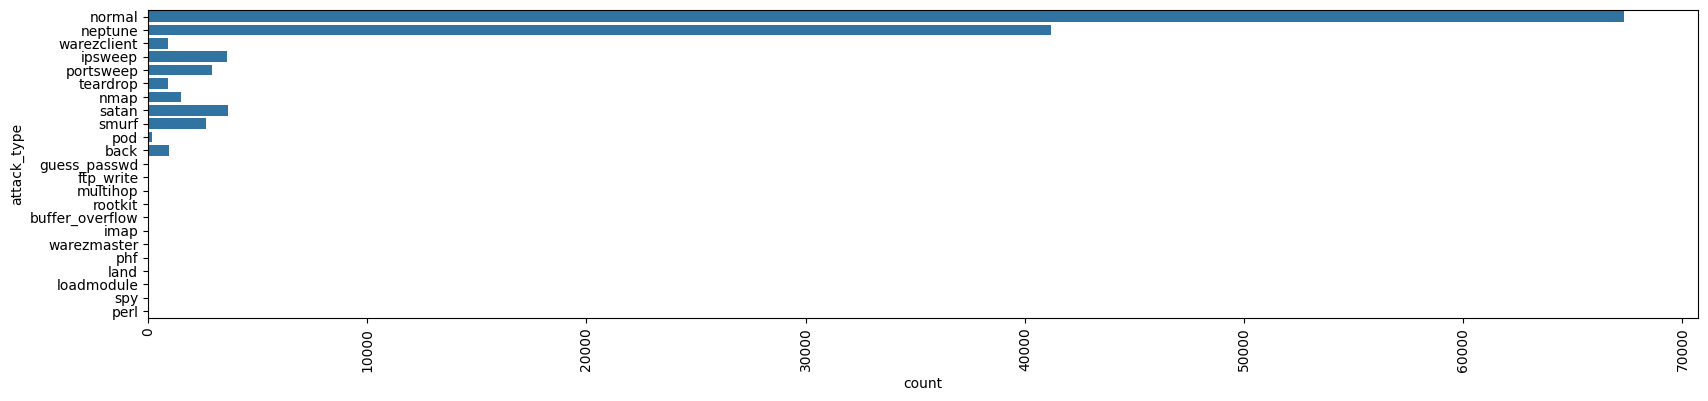

In [3]:
#generate bar plot for attack types
plt.figure(figsize=(20, 4))
sns.countplot(data['attack_type'])
plt.xticks(rotation=90)
plt.show()

In [4]:
print(data['service'].value_counts())

service
http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6860
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: count, Length: 70, dtype: int64


In [5]:
#identify categorical columns
print("Training dataset:")
for col_name in data.columns:
    if data[col_name].dtypes == 'object':
        unique_cat = len(data[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print() 
print("Distribution of categories in service:")
print(data['service'].value_counts().sort_values(ascending=False).head(10))      



Training dataset:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'attack_type' has 23 categories

Distribution of categories in service:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
Name: count, dtype: int64


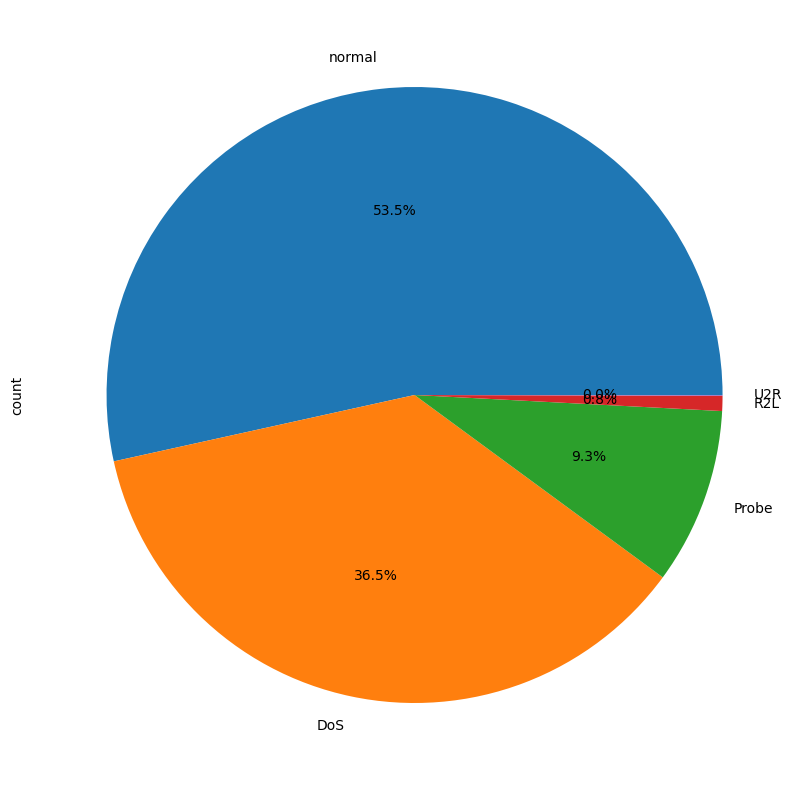

In [6]:
# #first group the data into normal and anomaly
# data['attack_type'] = data['attack_type'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')

#classify the anomaly class into four subtypes: DOS, Probe, R2L, U2R
DoS=['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
Probe=['ipsweep', 'nmap', 'portsweep', 'satan']
R2L=['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster']
U2R=['buffer_overflow', 'loadmodule', 'perl', 'rootkit']

def attack_class(attack):
    if attack in DoS:
        return 'DoS'
    elif attack in Probe:
        return 'Probe'
    elif attack in R2L:
        return 'R2L'
    elif attack in U2R:
        return 'U2R'
    else:
        return 'normal'
    
data['attack_class'] = data['attack_type'].apply(attack_class)

#generate pie plot for attack class
plt.figure(figsize=(20, 10))
data['attack_class'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()


In [7]:
data['attack_class'].value_counts()

attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

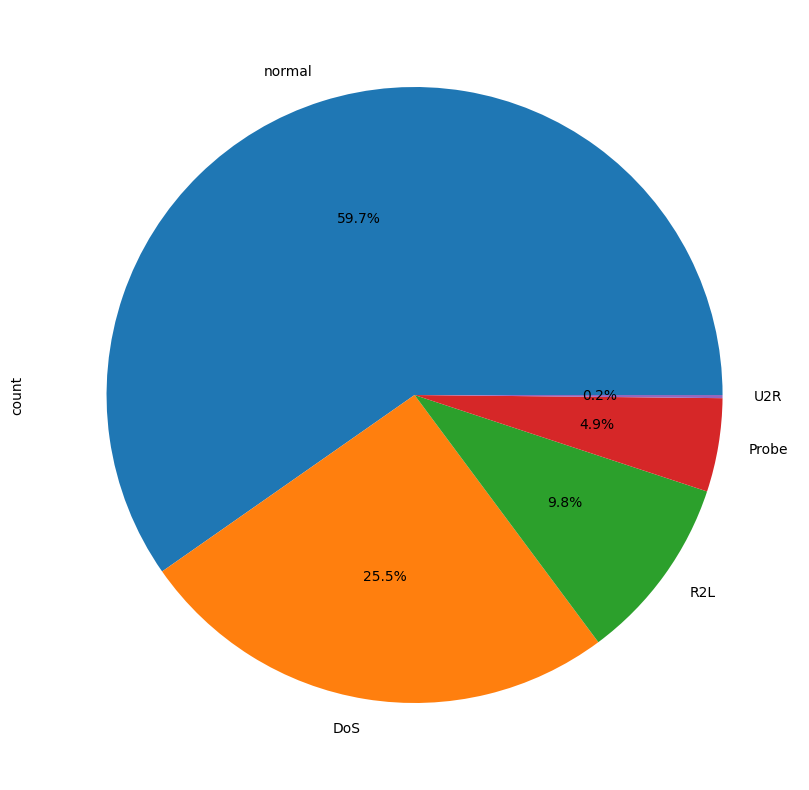

In [8]:

#classify the anomaly class into four subtypes: DOS, Probe, R2L, U2R
data_test['attack_class'] = data_test['attack_type'].apply(attack_class)

data_test['attack_class'].value_counts()

#generate pie plot for attack class
plt.figure(figsize=(20, 10))
data_test['attack_class'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [9]:
#for the data dataframe do the following. For the attack_class column, replace the values with normal and anomaly
data['attack_class'] = data['attack_class'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')

#drop the attack_type column and success_pred column
data.drop(['success_pred'], axis=1, inplace=True)
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,normal


In [10]:
data['attack_class'].value_counts()

attack_class
normal     67343
anomaly    58630
Name: count, dtype: int64

In [11]:
num=['float64','int64']
num_data=list(data.select_dtypes(include=num))

In [12]:
#data_test for the attacck_class column, replace the values with normal and anomaly
data_test['attack_class'] = data_test['attack_class'].apply(lambda x: 'normal' if x == 'normal' else 'anomaly')
data_test['attack_class'].value_counts()
data_test.drop(['success_pred'], axis=1, inplace=True)
data_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,normal
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,normal


In [13]:
#combine the training and testing data
combined_data = pd.concat([data, data_test],ignore_index=True)

In [14]:
X = combined_data.drop('attack_class', axis=1)
y = combined_data['attack_class']

In [15]:
"""
create the following pipelines:
The selected code is a complete pipeline for preprocessing and modeling an anomaly detection task using the `IsolationForest` and `LocalOutlierFactor` models from scikit-learn. Here's a step-by-step explanation:

1. A custom transformer `CustomLabelEncoder` is defined for one-hot encoding and hash encoding of categorical features.
2. Hashing is used on features whose categories are greater than 5 and label encoding for feature with categories equal to 2
2. The numerical and categorical features are selected using `make_column_selector`.
3. The numerical and categorical features are preprocessed separately.
4. These preprocessing steps are combined into a `ColumnTransformer`.
5. The combined preprocessing steps are applied to the combined data.
6. Feature names are extracted from the preprocessor.
7. The preprocessed data is converted back into a DataFrame.
8. The preprocessed data is split back into train and test sets.
9. The data is split into features (X) and target (y).
10. The data is further split into training and testing sets.
11. Two pipelines are created for the `IsolationForest` and `LocalOutlierFactor` models. Each pipeline includes scaling and the model itself.

This pipeline ensures that the same preprocessing steps are applied to both the training and testing data, and provides a convenient way to fit and evaluate the models.
"""
category_features = ['protocol_type', 'service', 'attack_type','flag']
numeric_features = combined_data.select_dtypes(include=['int64', 'float64']).columns


class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col in X.columns:
            if X[col].dtype == 'object' and col != 'attack_class':
                if X[col].nunique() > 5:
                    X[col] = X[col].apply(lambda x: hash(x))
                elif X[col].nunique() >2:
                    X[col] = OneHotEncoder().fit_transform(X[col].values.reshape(-1, 1)).toarray()
                else:
                    X[col] = LabelEncoder().fit_transform(X[col].values.reshape(-1, 1))
            elif col == 'attack_class':
                X[col] = LabelEncoder().fit_transform(X[col])
        return X
    def get_feature_names_out(self, input_features=None):
        return input_features
   
#transformer for numerical features then apply standard scaling
class NumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = StandardScaler().fit_transform(X)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return input_features

    
#combine the transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', NumTransformer(), numeric_features),
        ('cat', CustomLabelEncoder(), category_features)
    ])

#create a pipeline for the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

#apply transformation to the combined data
preprocessed_data_x = preprocessor.fit_transform(X)

#get feature names from the combined transformer
feature_names = preprocessor.get_feature_names_out()

#get actual nummber of columns in the preprocessed data
num_columns = preprocessed_data_x.shape[1]

#only use the first columns num_columns featture names 
feature_names = feature_names[:num_columns]

#convert the preprocessed data into a DataFrame
preprocessed_data = pd.DataFrame(preprocessed_data_x, columns=feature_names)

In [16]:
preprocessed_data.head()

,num__duration,num__src_bytes,num__dst_bytes,num__land,num__wrong_fragment,num__urgent,num__hot,num__num_failed_logins,num__logged_in,num__num_compromised,...,num__dst_host_same_src_port_rate,num__dst_host_srv_diff_host_rate,num__dst_host_serror_rate,num__dst_host_srv_serror_rate,num__dst_host_rerror_rate,num__dst_host_srv_rerror_rate,cat__protocol_type,cat__service,cat__attack_type,cat__flag
0,-0.112481,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,0.0,-4.196246e+18,2.882961e+18,3.937604e+18
1,-0.112481,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,0.0,8.443970e+18,2.882961e+18,3.937604e+18
2,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,0.0,3.592642e+18,-6.755648e+18,-6.741132e+18
3,-0.112481,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,0.0,-2.371921e+18,2.882961e+18,3.937604e+18
4,-0.112481,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,0.0,-2.371921e+18,2.882961e+18,3.937604e+18


In [17]:
#encode the categorical data
y_encoded=y.map({'normal':0,'anomaly':1})

#combine the preprocessed data and the encoded target
preprocessed_data = pd.concat([preprocessed_data, y_encoded], axis=1)
preprocessed_data.head()

,num__duration,num__src_bytes,num__dst_bytes,num__land,num__wrong_fragment,num__urgent,num__hot,num__num_failed_logins,num__logged_in,num__num_compromised,...,num__dst_host_srv_diff_host_rate,num__dst_host_serror_rate,num__dst_host_srv_serror_rate,num__dst_host_rerror_rate,num__dst_host_srv_rerror_rate,cat__protocol_type,cat__service,cat__attack_type,cat__flag,attack_class
0,-0.112481,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,0.0,-4.196246e+18,2.882961e+18,3.937604e+18,0
1,-0.112481,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,0.0,8.443970e+18,2.882961e+18,3.937604e+18,0
2,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.280650,1.736012,1.742295,-0.422074,-0.406815,0.0,3.592642e+18,-6.755648e+18,-6.741132e+18,1
3,-0.112481,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,0.0,-2.371921e+18,2.882961e+18,3.937604e+18,0
4,-0.112481,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,0.0,-2.371921e+18,2.882961e+18,3.937604e+18,0


In [18]:
# Split the preprocessed data back into train and test
data= preprocessed_data.iloc[:len(data)]
data_test = preprocessed_data.iloc[len(data):]
data_test.shape

(22544, 43)

In [19]:
#split the data into features and target
X = data.drop('attack_class', axis=1)
y = data['attack_class']
print(y.shape)
print(y.value_counts())

(125973,)
attack_class
0    67343
1    58630
Name: count, dtype: int64


In [20]:
#drop the num_num_outbound_cmds column
X.drop('num__num_outbound_cmds', axis=1, inplace=True)

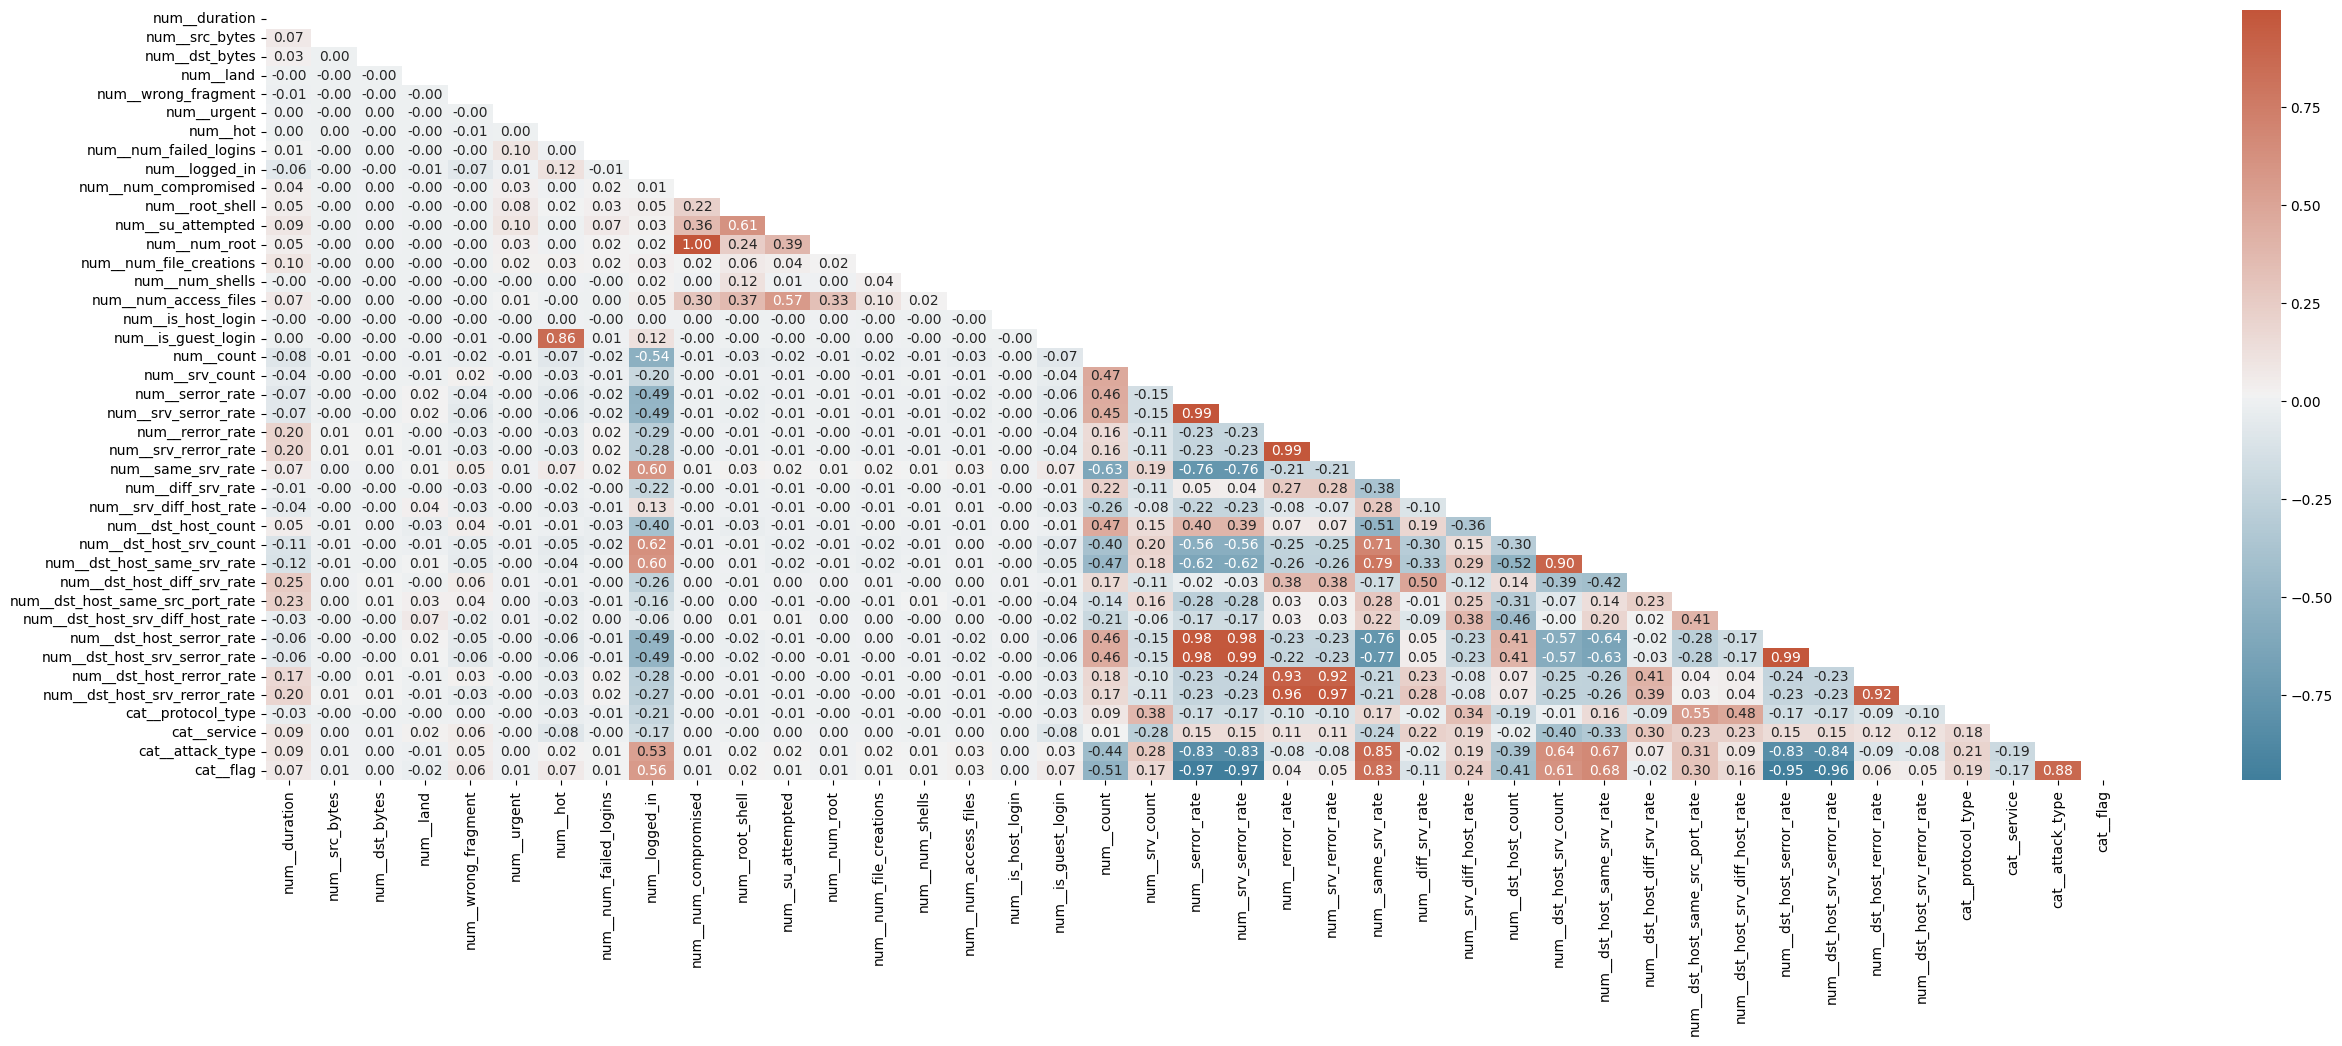

In [21]:
#check X for colinearity and plot the upper triangle of the correlation matrix
corr_matrix = X.corr()
mask=np.triu(np.ones_like(corr_matrix, dtype=bool))

#create a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#dram the heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f")
plt.show()


In [22]:
## Find pairs of features that have a correlation higher than 0.95
correlated_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            correlated_pairs.add((colname_i, colname_j))

# Print the correlated pairs
for pair in correlated_pairs:
    print(f"{pair[0]} is correlated to {pair[1]}")

# Choose one feature from each pair to drop
to_drop = set(pair[0] for pair in correlated_pairs)
# # Drop the chosen features
# X = X.drop(to_drop, axis=1)

cat__flag is correlated to num__dst_host_srv_serror_rate
num__srv_serror_rate is correlated to num__serror_rate
cat__flag is correlated to num__srv_serror_rate
num__dst_host_serror_rate is correlated to num__srv_serror_rate
num__dst_host_srv_serror_rate is correlated to num__dst_host_serror_rate
num__num_root is correlated to num__num_compromised
num__dst_host_srv_rerror_rate is correlated to num__srv_rerror_rate
num__srv_rerror_rate is correlated to num__rerror_rate
num__dst_host_srv_rerror_rate is correlated to num__rerror_rate
num__dst_host_serror_rate is correlated to num__serror_rate
num__dst_host_srv_serror_rate is correlated to num__srv_serror_rate
cat__flag is correlated to num__serror_rate
num__dst_host_srv_serror_rate is correlated to num__serror_rate
cat__flag is correlated to num__dst_host_serror_rate


In [23]:
# #introduce SMOTE to handle the imbalanced dataset
# from imblearn.over_sampling import SMOTE

# #initialize the SMOTE
# smote = SMOTE(random_state=42)

# #apply SMOTE to the data
# X, y = smote.fit_resample(X, y)

In [24]:

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [25]:
X_train.head()

,num__duration,num__src_bytes,num__dst_bytes,num__land,num__wrong_fragment,num__urgent,num__hot,num__num_failed_logins,num__logged_in,num__num_compromised,...,num__dst_host_same_src_port_rate,num__dst_host_srv_diff_host_rate,num__dst_host_serror_rate,num__dst_host_srv_serror_rate,num__dst_host_rerror_rate,num__dst_host_srv_rerror_rate,cat__protocol_type,cat__service,cat__attack_type,cat__flag
95141,-0.112481,-0.007397,-0.000580,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.408028,0.269937,-0.597720,-0.584813,-0.422074,-0.406815,0.0,-2.371921e+18,2.882961e+18,3.937604e+18
37486,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,0.0,3.592642e+18,-6.755648e+18,-6.741132e+18
34926,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.472829,-0.280650,-0.597720,-0.584813,2.676395,2.575756,0.0,-2.371921e+18,-6.755648e+18,6.904134e+17
34589,-0.112481,-0.007389,-0.004544,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,0.0,-2.371921e+18,2.882961e+18,3.937604e+18
11420,-0.112481,-0.007341,-0.004613,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,2.767228,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,0.0,8.443970e+18,2.882961e+18,3.937604e+18


In [35]:
iforest=IsolationForest(n_estimators=80, max_samples='auto', max_features=0.75, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
iforest.fit(X_train)

lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination='auto', n_jobs=-1)
lof.fit(X_train)


LocalOutlierFactor(n_jobs=-1)

In [27]:
from sklearn.metrics import classification_report
#predict the anomaly class using the IsolationForest model
y_pred_iforest = iforest.predict(X_test)

#predict the anomaly class using the LocalOutlierFactor model
y_pred_lof = lof.fit_predict(X_test)

#convert the anomaly class to normal and anomaly
y_pred_iforest = np.where(y_pred_iforest == -1, 1, 0)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

#print the classification report for the IsolationForest model
print("IsolationForest:")
print(classification_report(y_test, y_pred_iforest))

#print the classification report for the LocalOutlierFactor model
print("LocalOutlierFactor:")
print(classification_report(y_test, y_pred_lof))



IsolationForest:
              precision    recall  f1-score   support

           0       0.56      0.95      0.71     13422
           1       0.73      0.16      0.26     11773

    accuracy                           0.58     25195
   macro avg       0.65      0.55      0.48     25195
weighted avg       0.64      0.58      0.50     25195

LocalOutlierFactor:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70     13422
           1       0.83      0.04      0.08     11773

    accuracy                           0.55     25195
   macro avg       0.68      0.52      0.39     25195
weighted avg       0.67      0.55      0.41     25195



In [37]:
#use PCA to reduce the dimensionality of the data
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X)
# X_train_pca=pca.fit_transform(X_train)
# X_test_pca=pca.transform(X_test)
# #store X_train_pca in a DataFrame
X_train_pca = pd.DataFrame(X_train_pca)

#split the data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_train_pca, y, test_size=0.3, random_state=1234)

#fit the IsolationForest model on the PCA transformed data
iforest_pca = IsolationForest(n_estimators=80, max_samples='auto', max_features=0.25, bootstrap=True, n_jobs=-1, random_state=1234, verbose=0)
iforest_pca.fit(X_train_pca)

#fit the LocalOutlierFactor model on the PCA transformed data
lof_pca = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=-1)
lof_pca.fit(X_train_pca)

#predict the anomaly class using the IsolationForest model
y_pred_iforest_pca = iforest_pca.predict(X_test_pca)

#predict the anomaly class using the LocalOutlierFactor model
y_pred_lof_pca = lof_pca.fit_predict(X_test_pca)

#convert the anomaly class to normal and anomaly
y_pred_iforest_pca = np.where(y_pred_iforest_pca == -1, 1, 0)
y_pred_lof_pca = np.where(y_pred_lof_pca == -1, 1, 0)

#print the classification report for the IsolationForest model
print("IsolationForest with PCA:")
print(classification_report(y_test_pca, y_pred_iforest_pca))
# print(classification_report(y_test,y_pred_iforest_pca))

#print the classification report for the LocalOutlierFactor model
print("LocalOutlierFactor with PCA:")
print(classification_report(y_test_pca, y_pred_lof_pca))
# print(classification_report(y_test,y_pred_lof_pca))

IsolationForest with PCA:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     20135
           1       0.84      0.78      0.81     17657

    accuracy                           0.83     37792
   macro avg       0.83      0.82      0.82     37792
weighted avg       0.83      0.83      0.83     37792

LocalOutlierFactor with PCA:
              precision    recall  f1-score   support

           0       0.54      0.92      0.68     20135
           1       0.57      0.13      0.21     17657

    accuracy                           0.55     37792
   macro avg       0.56      0.52      0.44     37792
weighted avg       0.55      0.55      0.46     37792



In [38]:
#plot a precision-recall curve for the IsolationForest model and the LocalOutlierFactor model
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

#get inverted scores for the IsolationForest model
y_score_iforest = iforest_pca.decision_function(X_test_pca)
inverted_score=-y_score_iforest

#get inverted scores for the LocalOutlierFactor model
y_score_lof = lof_pca.negative_outlier_factor_
inverted_score_lof=-y_score_lof

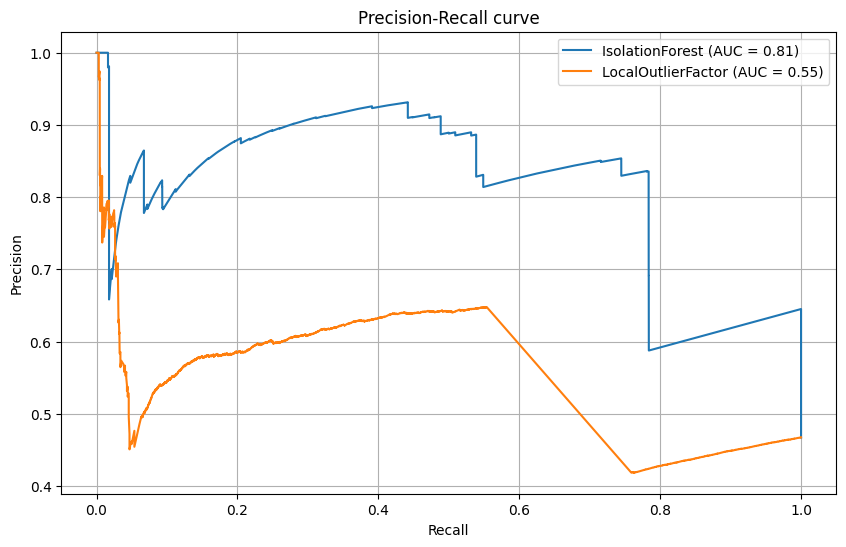

In [41]:
#plot the AUC-PR curve for the IsolationForest model and the LocalOutlierFactor model
plt.figure(figsize=(10, 6))
precision_iforest, recall_iforest, _ = precision_recall_curve(y_test_pca, inverted_score)
auc_score_iforest = auc(recall_iforest, precision_iforest)
plt.plot(recall_iforest, precision_iforest, label='IsolationForest (AUC = {:.2f})'.format(auc_score_iforest))

precision_lof, recall_lof, _ = precision_recall_curve(y_test_pca, inverted_score_lof)
auc_score_lof = auc(recall_lof, precision_lof)
plt.plot(recall_lof, precision_lof, label='LocalOutlierFactor (AUC = {:.2f})'.format(auc_score_lof))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#print AUC_PR for the IsolationForest model and the LocalOutlierFactor model
print("AUC-PR for IsolationForest: {:.2f}".format(auc_score_iforest))

AUC-PR for IsolationForest: 0.81


In [43]:
def estimate_feature_importance(iforest, n_features):
    """
    Estimates feature importance for an IsolationForest model based on the average depth at which each feature is used for splitting.

    Args:
        iforest_pca (IsolationForest): Trained isolation forest model.
        n_features (int): The number of features in the input data.

    Returns:
        np.ndarray: Array containing estimated feature importances for each feature.
    """
    # Initialize feature importance scores
    feature_importances = np.zeros(n_features)

    # Access isolation trees from the model
    estimators = iforest.estimators_

    # Loop through each isolation tree
    for tree in estimators:
        # Get feature and threshold for each internal node
        features = tree.tree_.feature[tree.tree_.feature >= 0.6]
        thresholds = tree.tree_.threshold[tree.tree_.feature >= 0.6]

        # Update feature importance scores
        for feature, threshold in zip(features, thresholds):
            feature_importances[feature] += 1

    # Normalize feature importance scores
    feature_importances /= len(estimators)

    return feature_importances


In [73]:
import types

# Define early stopping criteria (anomaly score threshold)
anomaly_score_threshold = 0.4  # You can adjust this value

# Define Isolation Forest model with early stopping logic
model = IsolationForest(n_estimators=80, max_samples='auto', max_features=0.25, bootstrap=True, n_jobs=-1, random_state=1234, verbose=0)

def custom_early_stopping(self, X):
    # Calculate anomaly scores using the original decision_function
    anomaly_scores = original_decision_function(X)

    # Stop growing branches if anomaly score exceeds the threshold
    for i in range(len(anomaly_scores)):
        if anomaly_scores[i] > anomaly_score_threshold:
            leaf_index = self.estimators_[i].apply(X[i].reshape(1, -1))  # Force tree growth for this point
            self.estimators_[i].tree_.children_left[leaf_index] = -1
            self.estimators_[i].tree_.children_right[leaf_index] = -1
            break
    return self

# Store the original decision_function before overriding it
original_decision_function = model.decision_function

# Override decision_function with custom_early_stopping
model.decision_function = types.MethodType(custom_early_stopping, model)
# Train the Isolation Forest model
model.fit(X_train_pca)

# Get anomaly scores for each data point
anomaly_scores = model.decision_function(X_train_pca)

In [74]:
class CustomIsolationForest(IsolationForest):
    def predict(self, X):
        # Calculate anomaly scores
        anomaly_scores = self.decision_function(X)

        # Make predictions based on anomaly scores
        predictions = np.where(anomaly_scores < 0, 1, 0)

        return predictions

# Create an instance of CustomIsolationForest
model = CustomIsolationForest()

# Train the model (replace with your actual training code)
model.fit(X_train_pca)

print("IsolationForest with Early Stopping:")
print(classification_report(y_train_pca, model.predict(X_train_pca)))

IsolationForest with Early Stopping:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76     47208
           1       0.72      0.78      0.75     40973

    accuracy                           0.76     88181
   macro avg       0.76      0.76      0.75     88181
weighted avg       0.76      0.76      0.76     88181



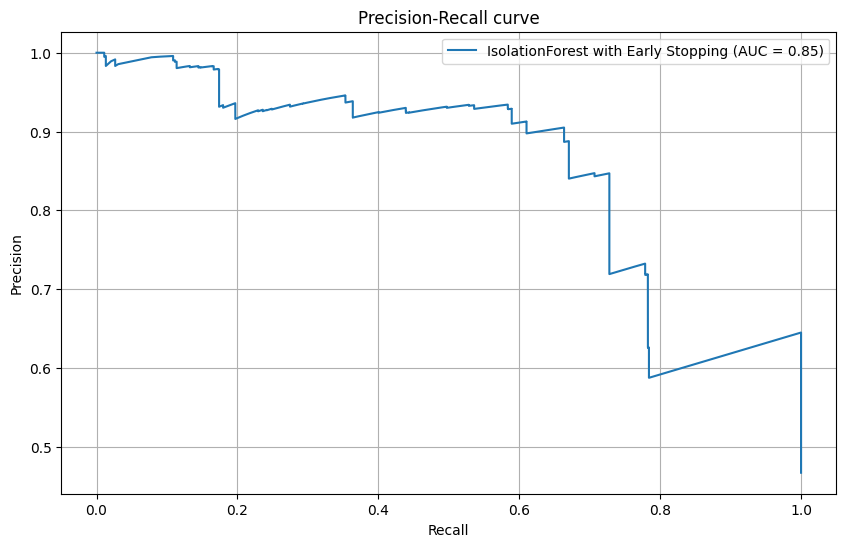

In [79]:
#plot the AUC-PR curve for the IsolationForest model with early stopping
plt.figure(figsize=(10, 6))
anomaly_score=-model.decision_function(X_test_pca)
precision, recall, _ = precision_recall_curve(y_test_pca, anomaly_score)
auc_score = auc(recall, precision)
plt.plot(recall, precision, label='IsolationForest with Early Stopping (AUC = {:.2f})'.format(auc_score))

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall curve')
plt.legend()
plt.grid(True)
plt.show()
